In [1]:
# ============================================================
# 04 - Comparação ML: XGBoost + Análise SHAP
# Fonte: SUSEP AUTOSEG (2019-2021)
# Autor: Arthur Pontes Motta
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Configurações visuais
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

# Caminhos
PROCESSED_PATH = '../data/processed'
FIGURES_PATH = '../reports/figures'

# ============================================================
# 1. CARREGAR DADOS
# ============================================================

df = pd.read_parquet(f'{PROCESSED_PATH}/autoseg_model.parquet')

features = (
    ['sexo_bin', 'faixa_etaria', 'idade_veiculo', 'log_is_media'] +
    [c for c in df.columns if c.startswith('regiao_')]
)

# Split temporal: treino 2019-2020 | teste 2021
df_train = df[df['ano'] < 2021].copy()
df_test  = df[df['ano'] == 2021].copy()

# Corrigir NaN
for split in [df_train, df_test]:
    split['idade_veiculo'] = split['idade_veiculo'].fillna(
        df_train['idade_veiculo'].median()
    )

X_train = df_train[features].astype(float)
X_test  = df_test[features].astype(float)

y_train = df_train['freq_colisao_rel']
y_test  = df_test['freq_colisao_rel']

print(f"Treino: {X_train.shape}")
print(f"Teste:  {X_test.shape}")
print(f"Zeros no target: {(y_train == 0).mean():.1%}")

c:\Users\Arthur\Documents\VS Code\Projetos\Precificação de Seguro Auto\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Treino: (6520676, 44)
Teste:  (2347730, 44)
Zeros no target: 90.2%


In [2]:
# ============================================================
# 2. XGBOOST — FREQUÊNCIA DE COLISÃO
# ============================================================

# Amostra para treino (mesmo tamanho do GLM para comparação justa)
SAMPLE_SIZE = 500_000
df_train_sample = df_train.sample(n=SAMPLE_SIZE, random_state=42)

X_train_s = df_train_sample[features].astype(float)
y_train_s = df_train_sample['freq_colisao_rel']

print(f"Amostra treino: {len(df_train_sample):,} linhas")
print("Treinando XGBoost...")

xgb_freq = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:tweedie',   # Tweedie é ideal para dados com muitos zeros
    tweedie_variance_power=1.5,
    random_state=42,
    n_jobs=-1,
    eval_metric='mae'
)

xgb_freq.fit(
    X_train_s, y_train_s,
    eval_set=[(X_test, y_test)],
    verbose=50
)

print("✓ XGBoost treinado!")

Amostra treino: 500,000 linhas
Treinando XGBoost...
[0]	validation_0-mae:0.05506
[50]	validation_0-mae:0.05375
[100]	validation_0-mae:0.05341
[150]	validation_0-mae:0.05326
[200]	validation_0-mae:0.05313
[250]	validation_0-mae:0.05305
[299]	validation_0-mae:0.05296
✓ XGBoost treinado!


In [3]:
# ============================================================
# 3. COMPARAÇÃO DE MÉTRICAS: GLM vs XGBoost
# ============================================================

# Predições XGBoost
pred_xgb = xgb_freq.predict(X_test)
pred_xgb = np.clip(pred_xgb, 0, None)  # sem valores negativos

# Prêmio puro observado
premio_puro_obs = df_test['indeniz_colisao'] / df_test['exposicao']

# Métricas XGBoost
mae_xgb  = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
corr_xgb = np.corrcoef(y_test, pred_xgb)[0, 1]

print("=" * 50)
print("COMPARAÇÃO: GLM vs XGBoost")
print("=" * 50)
print(f"{'Métrica':<15} {'GLM':>12} {'XGBoost':>12}")
print("-" * 40)
print(f"{'MAE':<15} {'0.0571':>12} {mae_xgb:>12.4f}")
print(f"{'RMSE':<15} {'3469.83':>12} {rmse_xgb:>12.4f}")
print(f"{'Correlação':<15} {'0.0408':>12} {corr_xgb:>12.4f}")

COMPARAÇÃO: GLM vs XGBoost
Métrica                  GLM      XGBoost
----------------------------------------
MAE                   0.0571       0.0530
RMSE                 3469.83       0.1387
Correlação            0.0408       0.0851


Calculando SHAP values (amostra de 10k)...


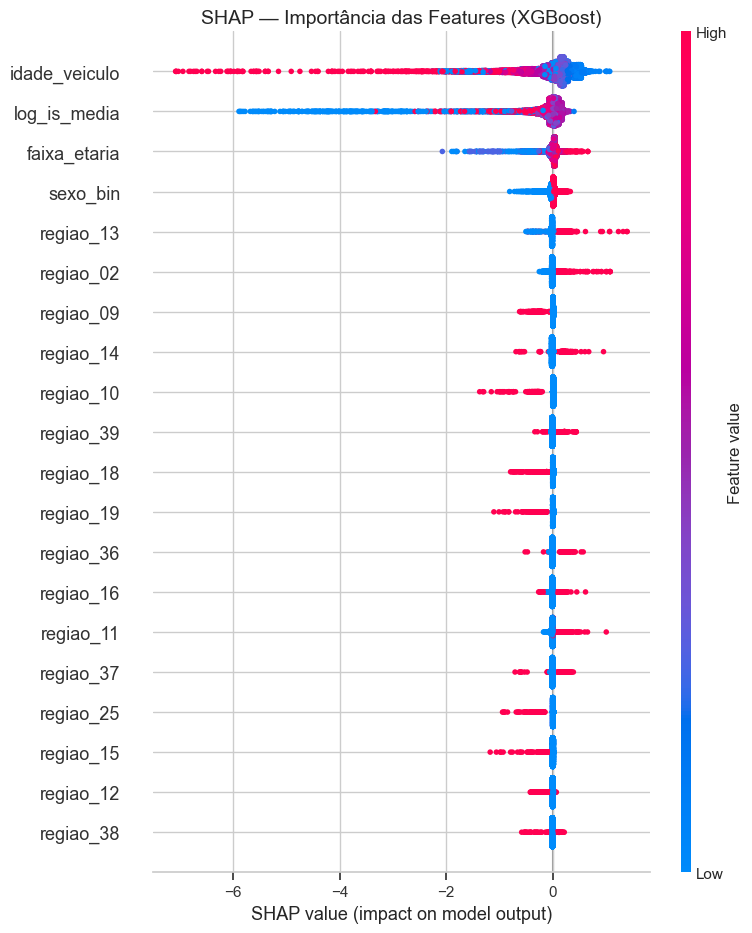

Figura salva: 04_shap_summary.png


In [4]:
# ============================================================
# 4. ANÁLISE SHAP — EXPLICABILIDADE DO XGBOOST
# ============================================================

print("Calculando SHAP values (amostra de 10k)...")
rng = np.random.default_rng(42)
idx_shap = rng.choice(len(X_test), 10_000, replace=False)
X_shap = X_test.iloc[idx_shap]

explainer   = shap.TreeExplainer(xgb_freq)
shap_values = explainer.shap_values(X_shap)

# 1. Summary plot — importância global
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, X_shap, show=False)
plt.title('SHAP — Importância das Features (XGBoost)', fontsize=14)
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/04_shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figura salva: 04_shap_summary.png")

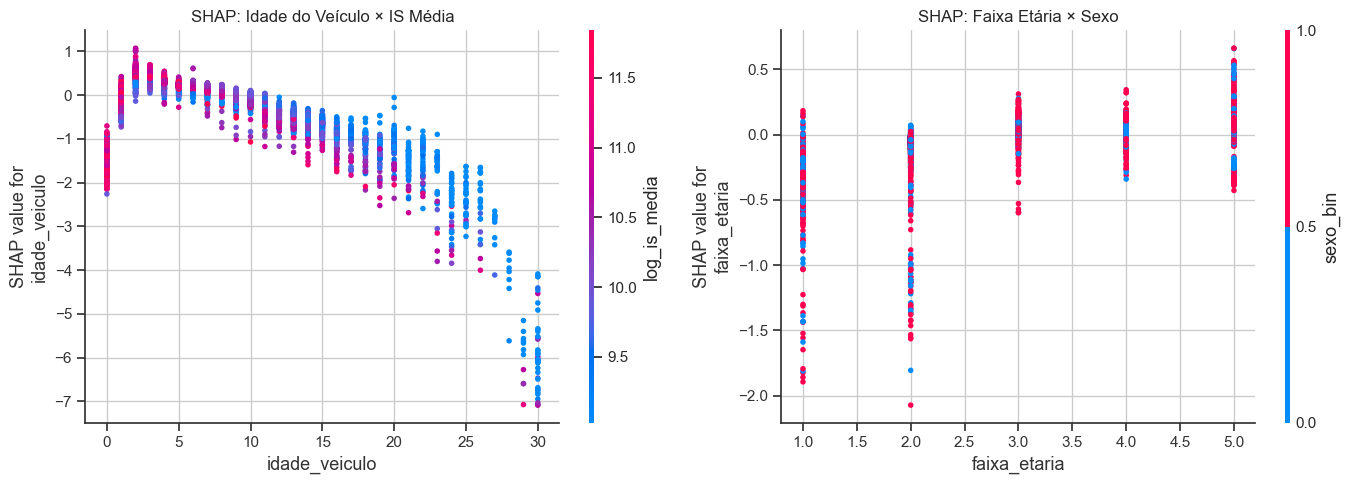

Figura salva: 04_shap_dependence.png


In [5]:
# ============================================================
# 5. SHAP DEPENDENCE PLOT — TOP FEATURES
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Dependence plot: idade_veiculo
shap.dependence_plot(
    'idade_veiculo', shap_values, X_shap,
    interaction_index='log_is_media',
    ax=axes[0], show=False
)
axes[0].set_title('SHAP: Idade do Veículo × IS Média')

# 2. Dependence plot: faixa_etaria
shap.dependence_plot(
    'faixa_etaria', shap_values, X_shap,
    interaction_index='sexo_bin',
    ax=axes[1], show=False
)
axes[1].set_title('SHAP: Faixa Etária × Sexo')

plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/04_shap_dependence.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figura salva: 04_shap_dependence.png")